# Active Learning Color Mixing — Complete Run

This notebook runs the full active learning experiment:

1. **Setup** — imports, config, robot connection
2. **Robot Precheck** — verify OT-2 connectivity
3. **ML Offline Test** — validate GP + acquisition with synthetic data
4. **Execute** — run the active learning loop on the robot
5. **Results** — visualize convergence

### Prerequisites
```bash
conda activate automation
pip install -e OpenOT2
pip install -r requirements.txt
```

---
## 1. Setup

Import modules and load experiment configuration.

In [1]:
import sys, os, logging
import numpy as np
import yaml

# Add project root to path so we can import src/
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

# OpenOT2 — robot control + operations
from openot2 import OT2Client, OT2Operations, setup_logging

# Project modules — ML + pipeline + color extraction
from src.ml import (
    CorrelatedMultiOutputGP, IndependentMultiOutputGP,
    AcquisitionFunction, create_surrogate, color_distance, sample_simplex,
)
from src.color_extraction import extract_experiment_rgb, visualize_grid, white_balance
from src.pipeline import run_active_learning_loop

setup_logging(level=logging.INFO)

# Load experiment config
with open("../configs/experiment.yaml") as f:
    config = yaml.safe_load(f)

ROBOT_IP = config["robot"]["ip"]
TARGET_RGB = np.array(config["target_color"])
TOTAL_VOLUME = config["total_volume_ul"]

print(f"Target color: {TARGET_RGB}")
print(f"Total volume: {TOTAL_VOLUME} µL")
print(f"Robot IP: {ROBOT_IP}")
print(f"ML model: {config['ml']['model']}")
print("Setup complete.")

Target color: [128   0 255]
Total volume: 200 µL
Robot IP: 169.254.8.56
ML model: correlated_gp
Setup complete.


---
## 2. Robot Precheck

Verify the OT-2 is reachable before starting.

In [2]:
import requests

def precheck_robot(robot_ip: str, port: int = 31950) -> bool:
    """Check if the OT-2 robot is reachable."""
    url = f"http://{robot_ip}:{port}/health"
    try:
        r = requests.get(url, headers={"Opentrons-Version": "*"}, timeout=5)
        r.raise_for_status()
        health = r.json()
        print(f"Robot reachable at {robot_ip}")
        print(f"  Name: {health.get('name', 'N/A')}")
        print(f"  API version: {health.get('api_version', 'N/A')}")
        return True
    except requests.ConnectionError:
        print(f"Cannot reach robot at {robot_ip}:{port}")
        print("Check that the robot is powered on and connected.")
        return False
    except Exception as e:
        print(f"Health check error: {e}")
        return False

robot_ok = precheck_robot(ROBOT_IP)

Cannot reach robot at 169.254.8.56:31950
Check that the robot is powered on and connected.


In [ ]:
from openot2.vision import precheck_cameras                                    
                                                                                
camera_id = config.get("camera", {}).get("device_id", 0)                       
precheck_cameras(expected_id=camera_id)  

---
## 3. ML Offline Test

Validate the 3-GP surrogate model + acquisition function with synthetic data before running on the robot.

In [20]:
# Generate synthetic color-mixing data
# Simple model: RGB proportional to dye volume fraction + noise
rng = np.random.default_rng(42)
X_syn = sample_simplex(15, total_volume=TOTAL_VOLUME, d=3, rng=rng)
Y_syn = np.column_stack([
    255 * X_syn[:, 0] / TOTAL_VOLUME,
    255 * X_syn[:, 1] / TOTAL_VOLUME,
    255 * X_syn[:, 2] / TOTAL_VOLUME,
]) + rng.normal(0, 5, (15, 3))
Y_syn = np.clip(Y_syn, 0, 255)

print(f"Synthetic data: {X_syn.shape[0]} samples")
print(f"Volume sums (should all be {TOTAL_VOLUME}): {X_syn.sum(axis=1)[:3].round(1)}")
print(f"Sample volumes: {X_syn[0].round(1)}")
print(f"Sample RGB:     {Y_syn[0].round(1)}")

Synthetic data: 15 samples
Volume sums (should all be 200): [200. 200. 200.]
Sample volumes: [67.5 65.6 66.9]
Sample RGB:     [87.2 84.2 86.4]


In [21]:
# Fit correlated multi-output GP (learns R-G-B correlations)
bounds = np.array([config["volume_bounds"]["min"], config["volume_bounds"]["max"]], dtype=float)

surrogate = create_surrogate(model_type=config["ml"]["model"], bounds=bounds, total_volume=TOTAL_VOLUME)
surrogate.fit(X_syn[:10], Y_syn[:10])

# Predict on held-out data
mean_rgb, std_rgb = surrogate.predict(X_syn[10:])
print("\nPredictions on held-out data:")
for i in range(5):
    actual = Y_syn[10 + i]
    pred = mean_rgb[i]
    print(f"  Actual: ({actual[0]:.0f},{actual[1]:.0f},{actual[2]:.0f}) | "
          f"Predicted: ({pred[0]:.0f},{pred[1]:.0f},{pred[2]:.0f}) ± "
          f"({std_rgb[i][0]:.0f},{std_rgb[i][1]:.0f},{std_rgb[i][2]:.0f})")

[ML] CorrelatedGP fitted on 10 points (3 correlated outputs)

Predictions on held-out data:
  Actual: (44,137,80) | Predicted: (115,209,-60) ± (39,56,56)
  Actual: (43,88,125) | Predicted: (119,66,71) ± (37,53,53)
  Actual: (55,55,142) | Predicted: (141,-33,142) ± (39,55,56)
  Actual: (23,111,111) | Predicted: (76,134,48) ± (37,53,54)
  Actual: (123,6,126) | Predicted: (264,-136,119) ± (50,72,72)


In [22]:
# Test acquisition function
acq = AcquisitionFunction(kind="EI", target_rgb=TARGET_RGB, total_volume=TOTAL_VOLUME)
suggestion = acq.suggest(surrogate, n_candidates=3, n_random=10000)

print(f"\nTarget RGB: {TARGET_RGB}")
print(f"\nTop 3 suggested experiments:")
for i, v in enumerate(suggestion):
    pred_rgb, _ = surrogate.predict(v.reshape(1, 3))
    dist = color_distance(pred_rgb[0], TARGET_RGB)
    print(f"  {i+1}. Vr={v[0]:.1f}, Vg={v[1]:.1f}, Vb={v[2]:.1f} "
          f"| Pred RGB: ({pred_rgb[0][0]:.0f},{pred_rgb[0][1]:.0f},{pred_rgb[0][2]:.0f}) "
          f"| Distance: {dist:.1f}")

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=47.4, Vg=1.1, Vb=151.5 | Pred RGB=(142,-178,277) | Score=0.2
[ML] Suggested: Vr=20.6, Vg=12.8, Vb=166.6 | Pred RGB=(70,-145,316) | Score=0.3
[ML] Suggested: Vr=52.5, Vg=9.5, Vb=138.0 | Pred RGB=(157,-147,233) | Score=0.5

Target RGB: [128   0 255]

Top 3 suggested experiments:
  1. Vr=47.4, Vg=1.1, Vb=151.5 | Pred RGB: (142,-178,277) | Distance: 179.6
  2. Vr=20.6, Vg=12.8, Vb=166.6 | Pred RGB: (70,-145,316) | Distance: 167.9
  3. Vr=52.5, Vg=9.5, Vb=138.0 | Pred RGB: (157,-147,233) | Distance: 151.1


---
## 4. Manual Robot Test (Optional)

Test a single transfer using `OT2Operations` before running the full experiment.
Skip this section if you've already validated the hardware.

In [3]:
# Connect to robot and create a test run
client = OT2Client(ROBOT_IP)
run_id = client.create_run()

# Create operations helper with default rinse settings from config
clean_cfg = config.get("cleaning", {})
ops = OT2Operations(
    client=client,
    rinse_cycles=clean_cfg.get("rinse_cycles", 3),
    rinse_volume=clean_cfg.get("rinse_volume_ul", 250),
)

# Load dual pipettes
right_pip = client.load_pipette(config["pipettes"]["right"]["name"], "right")
left_pip  = client.load_pipette(config["pipettes"]["left"]["name"], "left")

# Load labware — new deck layout:
#   1=plate, 4=wash, 5=water, 7=red, 8=green, 9=blue, 10=tips-L, 11=tips-R
lab = config["labware"]
tiprack_r  = client.load_labware(lab["tipracks"][0]["name"], lab["tipracks"][0]["slot"])  # slot 11
tiprack_l  = client.load_labware(lab["tipracks"][1]["name"], lab["tipracks"][1]["slot"])  # slot 10
red_src    = client.load_labware(lab["sources"]["red"]["name"], lab["sources"]["red"]["slot"])      # slot 7
green_src  = client.load_labware(lab["sources"]["green"]["name"], lab["sources"]["green"]["slot"])  # slot 8
blue_src   = client.load_labware(lab["sources"]["blue"]["name"], lab["sources"]["blue"]["slot"])    # slot 9
water_src  = client.load_labware(lab["water"]["name"], lab["water"]["slot"])              # slot 5
cleaning   = client.load_labware(lab["cleaning"]["name"], lab["cleaning"]["slot"])        # slot 4
plate      = client.load_labware(lab["dispense"]["name"], lab["dispense"]["slot"])        # slot 1

print(f"Run: {run_id}")
print(f"Pipettes: right={right_pip}, left={left_pip}")
print(f"Plate: slot {lab['dispense']['slot']}")
print(f"Dyes: R=slot {lab['sources']['red']['slot']}, G=slot {lab['sources']['green']['slot']}, B=slot {lab['sources']['blue']['slot']}")
print("Labware loaded. Ready for manual test.")

[openot2.client] POST http://169.254.8.56:31950/runs
[openot2.client] Run created: afbb4852-70a3-4371-93bb-b22738c20733
[openot2.client] loadPipette: p300_multi_gen2 (right)
[openot2.client] Pipette ID: 854ff393-a988-4286-ba15-2b775c51636a (mount=right)
[openot2.client] loadPipette: p300_single_gen2 (left)
[openot2.client] Pipette ID: 31ab2b3d-0e40-4c8c-b81b-4c5b4390a2a4 (mount=left)
[openot2.client] loadLabware: opentrons_96_filtertiprack_200ul in slot 11
[openot2.client] Labware ID: c05b9075-bef3-4b5d-8577-acd36f1dd733
[openot2.client] loadLabware: opentrons_96_filtertiprack_200ul in slot 10
[openot2.client] Labware ID: ee85d7cd-339b-4d6f-98dc-7f1dd6e5903c
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 7
[openot2.client] Labware ID: cf8c4e95-89bc-4401-a273-f75760fbc037
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 8
[openot2.client] Labware ID: b8762eb1-c2c9-48e6-b41d-3c1618c720e8
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 9
[openot2.cli

In [ ]:
# Example: single-channel control transfer (left pipette)
# Dispense pure red dye from slot 7 into control row A
client.use_pipette("left")

ops.transfer(
    tiprack_id=tiprack_l,
    source_id=red_src,         # Red dye reservoir (slot 7)
    dest_id=plate,
    tip_well="A1",             # Red control tip
    source_well="A1",          # Well A1 in red reservoir
    dest_well="A1",            # Row A, column 1
    volume=200.0,              # Max 200 uL (filter tip limit)
    cleaning_id=cleaning,
    rinse_col="A6",            # Control rinse column
)

print("Single-channel control transfer complete.")

In [ ]:
# Example: 8-channel experiment transfer (right pipette)
# Dispense red dye from slot 7 into experiment rows E-H
client.use_pipette("right")

ops.transfer(
    tiprack_id=tiprack_r,
    source_id=red_src,         # Red dye reservoir (slot 7)
    dest_id=plate,
    tip_well="A1",             # Red experiment tips (col 1, rows E-H only)
    source_well="A1",          # Well A1 in red reservoir
    dest_well="A1",            # Column 1, rows E-H get dye
    volume=100.0,
    cleaning_id=cleaning,
    rinse_col="A1",            # Red rinse column
)

print("8-channel experiment transfer complete.")

### 4a. Water Transfer Test

Dispense pure water from slot 5 into control row D (white baseline).
This verifies the single-channel left pipette can access the water reservoir.

In [14]:
# Water transfer test — single-channel left pipette
# Dispense 200 uL pure water from slot 5 into row D, column 1
client.use_pipette("left")

ops.transfer(
    tiprack_id=tiprack_l,
    source_id=water_src,       # Pure water reservoir (slot 5)
    dest_id=plate,
    tip_well="D1",             # Dedicated Water control tip
    source_well="A1",          # Well A1 in water reservoir
    dest_well="D1",            # Row D, column 1 (white baseline)
    volume=200.0,              # Max 200 uL (filter tip limit)
    cleaning_id=cleaning,
    rinse_col="A5",            # Water rinse column
)

print("Water transfer complete — row D1 should now contain pure water.")

[openot2.client] Active pipette switched to left (135fa41d-2d7a-49a7-9514-c24c7f5448af)
[openot2.operations] transfer: A1 -> D1 (200.0 uL) tip=D1
[openot2.client] pickUpTip: labware=3d0037c3-3ff3-4dd4-bc5d-e1f9f2320524 well=D1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into D1 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A5 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A5 origin=bottom
[openot2.client] dispense: 200uL into A5 origin=bottom
[openot2.client] aspirate: 200uL from A5 origin=bottom
[openot2.client] dispense: 200uL into A5 origin=bottom
[openot2.client] aspirate: 200uL from A5 origin=bottom
[openot2.client] dispense: 200uL into A5 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=3d0037c3-3ff3-4dd4-bc5d-e1f9f2320524 well=D1
Water transfer complete — row D1 should now contain pure water.


### 4b. Camera & Color Extraction Test

Capture a plate image with the overhead USB camera and run the full color extraction pipeline.
Verifies: camera connectivity, image quality, grid alignment, well detection, and white balance.

In [ ]:
# Scan for available cameras using OpenOT2's list_cameras()
from openot2.vision import USBCamera, list_cameras

cameras = list_cameras(max_id=5)
print(f"Found {len(cameras)} camera(s):")
for cam_info in cameras:
    print(f"  Camera {cam_info['id']}: {cam_info['width']}x{cam_info['height']}")

if not cameras:
    raise RuntimeError("No cameras found — check USB connection")

[openot2.client] home
Robot homed. Waiting 5s for vibration to settle...


2026-02-19 12:28:39.031 python[29405:197637] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


[openot2.vision.camera] Camera 1 opened (1920x1080, backend=1200)
[openot2.vision.camera] Camera released
Image captured: ../data/test_captures/camera_test_20260219_122840.jpg


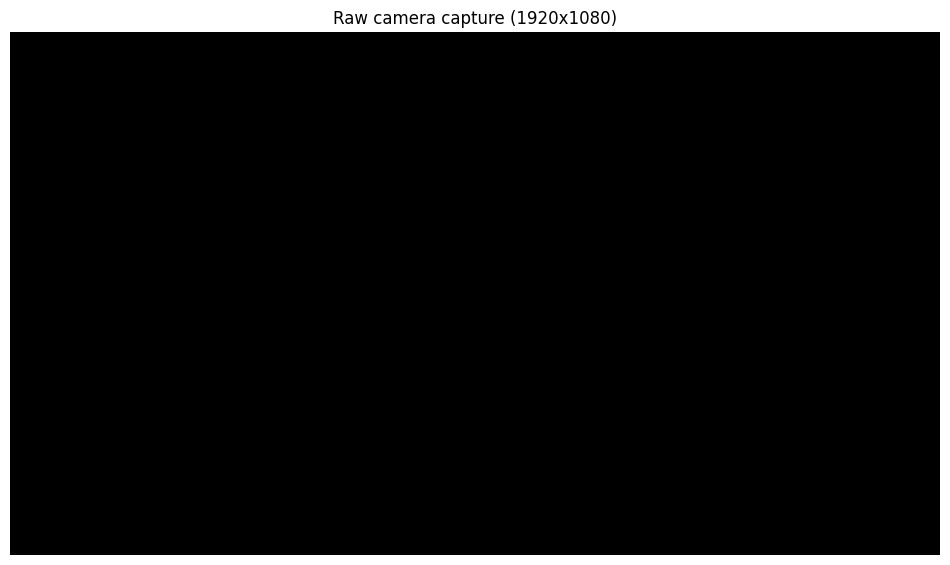

Image size: 1920x1080


In [5]:
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
from src.color_extraction import (
    extract_plate_rgb, extract_experiment_rgb, visualize_grid,
    white_balance, ROW_LABELS, N_ROWS, N_COLS,
)

# --- Step 1: Capture image ---
# Home robot first so gantry doesn't block the camera view
client.home()
print("Robot homed. Waiting 5s for vibration to settle...")
import time; time.sleep(5)

from openot2.vision import USBCamera

cam_cfg = config.get("camera", {})
camera = USBCamera(
    camera_id=cam_cfg.get("device_id", 0),
    width=cam_cfg.get("width", 1920),
    height=cam_cfg.get("height", 1080),
    warmup_frames=cam_cfg.get("warmup_frames", 10),
)

os.makedirs("../data/test_captures", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
test_image_path = f"../data/test_captures/camera_test_{timestamp}.jpg"

with camera:
    frame = camera.capture()
    if frame is None:
        raise RuntimeError("Camera capture returned None — check camera connection")
    cv2.imwrite(test_image_path, frame)

print(f"Image captured: {test_image_path}")

# --- Step 2: Display raw image ---
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 7))
plt.imshow(img_rgb)
plt.title(f"Raw camera capture ({frame.shape[1]}x{frame.shape[0]})")
plt.axis("off")
plt.show()

print(f"Image size: {frame.shape[1]}x{frame.shape[0]}")

In [ ]:
# --- Step 3: Grid overlay — verify well alignment ---
grid_path = visualize_grid(test_image_path)
grid_bgr = cv2.imread(grid_path)
grid_rgb = cv2.cvtColor(grid_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 7))
plt.imshow(grid_rgb)
plt.title("Grid overlay — check that green circles align with wells")
plt.axis("off")
plt.show()

print(f"Grid overlay saved: {grid_path}")
print("If circles don't align, adjust DEFAULT_GRID in src/color_extraction.py")

In [ ]:
# --- Step 4: Extract all 96 well colors + print grid report ---
plate_rgb = extract_plate_rgb(test_image_path)

# Print compact grid table (rows A-H x columns 1-12)
def rgb_label(rgb):
    """Short label: dominant channel or hex-ish."""
    r, g, b = rgb
    if max(r, g, b) < 30:
        return "BLK"
    if min(r, g, b) > 200:
        return "WHT"
    if r > g and r > b:
        return f"R{int(r)}"
    if g > r and g > b:
        return f"G{int(g)}"
    return f"B{int(b)}"

print(f"\nExtracted RGB from {test_image_path}")
print(f"\n{'':>4}", end="")
for c in range(1, 13):
    print(f"{'Col'+str(c):>10}", end="")
print()
print("    " + "-" * 120)

for r in range(N_ROWS):
    row_label = ROW_LABELS[r]
    print(f"  {row_label} |", end="")
    for c in range(N_COLS):
        rgb = plate_rgb[r, c]
        print(f" ({int(rgb[0]):3},{int(rgb[1]):3},{int(rgb[2]):3})", end="")
    print()

print()

# --- Step 5: Column 1 detail (controls + experiments if dispensed) ---
print("Column 1 detail:")
for r in range(N_ROWS):
    row_label = ROW_LABELS[r]
    rgb = plate_rgb[r, 0]
    role = {0: "Red ctrl", 1: "Grn ctrl", 2: "Blu ctrl", 3: "Water ctrl",
            4: "Exp E", 5: "Exp F", 6: "Exp G", 7: "Exp H"}.get(r, "?")
    print(f"  {row_label}1 ({role:>10}): R={rgb[0]:6.1f}  G={rgb[1]:6.1f}  B={rgb[2]:6.1f}")

# --- Step 6: White balance test using water well D1 ---
water_rgb = plate_rgb[3, 0]  # Row D = index 3, col 1 = index 0
print(f"\nWater reference (D1): R={water_rgb[0]:.1f}, G={water_rgb[1]:.1f}, B={water_rgb[2]:.1f}")

if max(water_rgb) > 50:  # Only if water well has liquid
    corrected = white_balance(plate_rgb[:, 0], water_rgb)
    print("\nWhite-balanced column 1:")
    for r in range(N_ROWS):
        row_label = ROW_LABELS[r]
        raw = plate_rgb[r, 0]
        cor = corrected[r]
        print(f"  {row_label}1: raw=({raw[0]:.0f},{raw[1]:.0f},{raw[2]:.0f}) "
              f"-> corrected=({cor[0]:.0f},{cor[1]:.0f},{cor[2]:.0f})")
else:
    print("Water well appears empty (too dark). Skipping white balance test.")

# --- Step 7: Visual color swatch ---
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(14, 5))
for r in range(N_ROWS):
    for c in range(N_COLS):
        rgb_norm = np.clip(plate_rgb[r, c] / 255.0, 0, 1)
        axes[r, c].set_facecolor(rgb_norm)
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        if r == 0:
            axes[r, c].set_title(str(c + 1), fontsize=8)
        if c == 0:
            axes[r, c].set_ylabel(ROW_LABELS[r], fontsize=9, rotation=0, labelpad=15)

plt.suptitle("Extracted well colors (raw)", fontsize=12)
plt.tight_layout()
plt.show()

print("\nCamera test complete.")

In [ ]:
# Home the robot after manual testing
client.home()
print("Robot homed.")

### 4c. Capture Column 1 & Seed the GP

If you've already dispensed column 1 manually (controls + experiment), run this cell to:
1. Capture the plate image with the overhead camera
2. Extract RGB values from column 1 (controls A-D + experiments E-H)
3. Store the volumes you used and observed RGB as seed data

The seed data (`seed_X`, `seed_Y`) will be passed to `run_active_learning_loop()` so the GP starts informed.

Image: ../data/seed_captures/col1_seed_20260219_125504.jpg  (1920x1080)


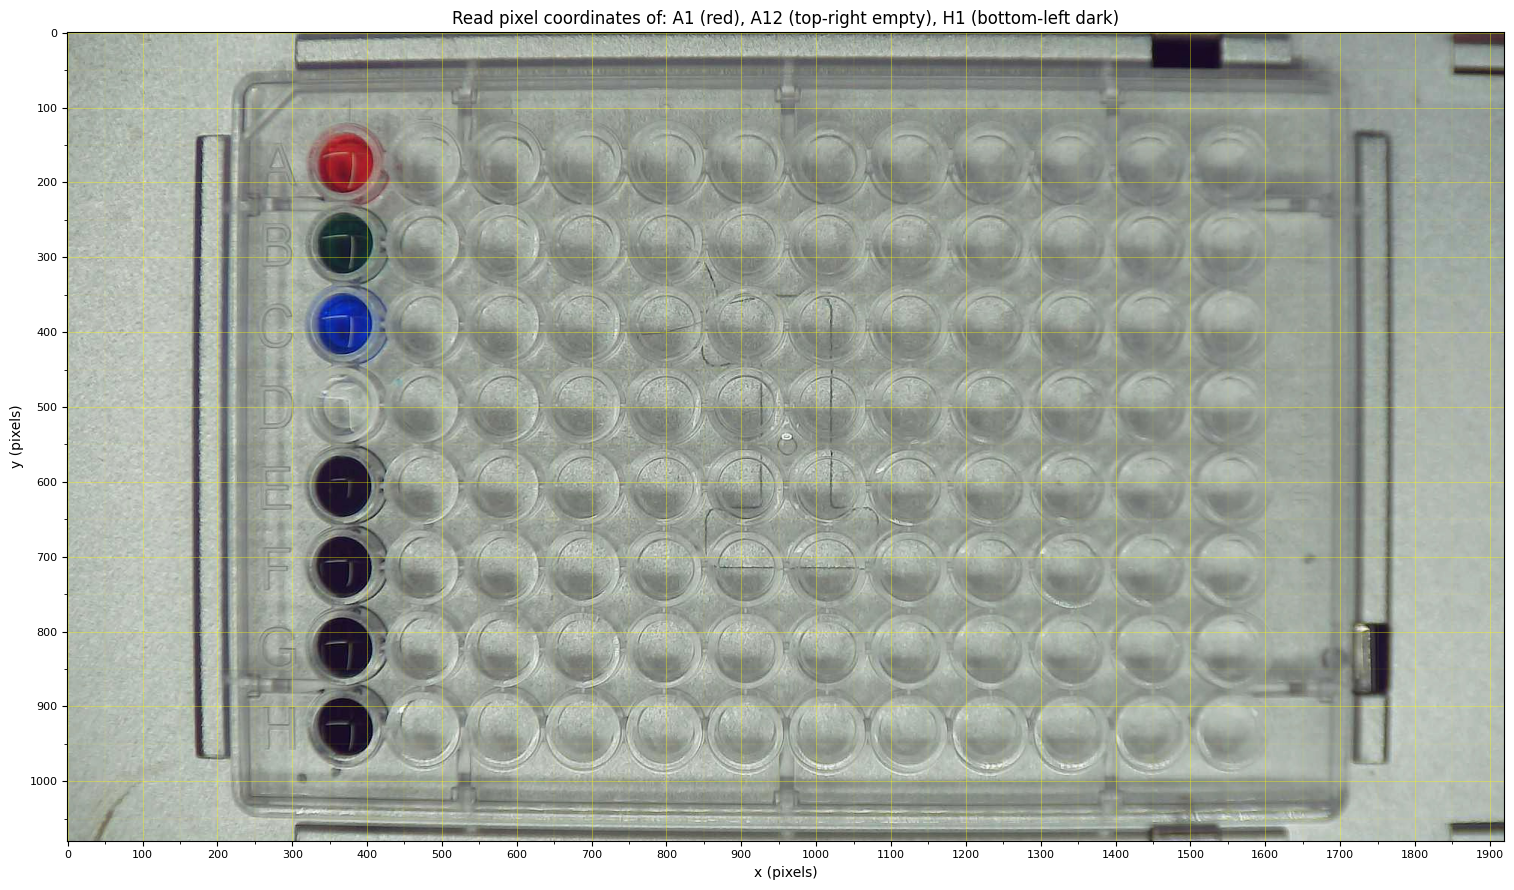


Find these 3 wells and note their (x, y) pixel centers:
  A1  = top-left well (RED dye)
  A12 = top-right well (empty)
  H1  = bottom-left well (dark experiment)

Enter the values in the next cell.


In [15]:
# ==========================================================
# Grid Calibration — read coordinates from image, enter below
# ==========================================================
# Step 1: Run this cell to see the plate image with pixel coordinates
# Step 2: Read the (x, y) pixel position of wells A1, A12, and H1
# Step 3: Enter the values in the next cell
# ==========================================================
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Find latest plate image
import glob
seed_images = sorted(glob.glob("../data/seed_captures/col1_seed_*.jpg"))
test_images = sorted(glob.glob("../data/test_captures/camera_test_*.jpg"))
cal_image = (seed_images or test_images or [None])[-1]
if cal_image is None:
    raise RuntimeError("No plate image found — run camera capture first")

img_bgr = cv2.imread(cal_image)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img_rgb.shape[:2]

print(f"Image: {cal_image}  ({w}x{h})")

fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(img_rgb)

# Show pixel grid for easy reading
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.grid(True, which='major', color='yellow', linewidth=0.5, alpha=0.5)
ax.grid(True, which='minor', color='yellow', linewidth=0.2, alpha=0.3)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel("x (pixels)", fontsize=10)
ax.set_ylabel("y (pixels)", fontsize=10)
ax.set_title("Read pixel coordinates of: A1 (red), A12 (top-right empty), H1 (bottom-left dark)", fontsize=12)

plt.tight_layout()
plt.show()

print("\nFind these 3 wells and note their (x, y) pixel centers:")
print("  A1  = top-left well (RED dye)")
print("  A12 = top-right well (empty)")
print("  H1  = bottom-left well (dark experiment)")
print("\nEnter the values in the next cell.")

Computed grid:
  origin:     (380, 240)
  spacing:    (106, 98)
  roi_radius: 34
[VISION] Grid overlay saved: ../data/seed_captures/col1_seed_20260219_125504_grid.jpg


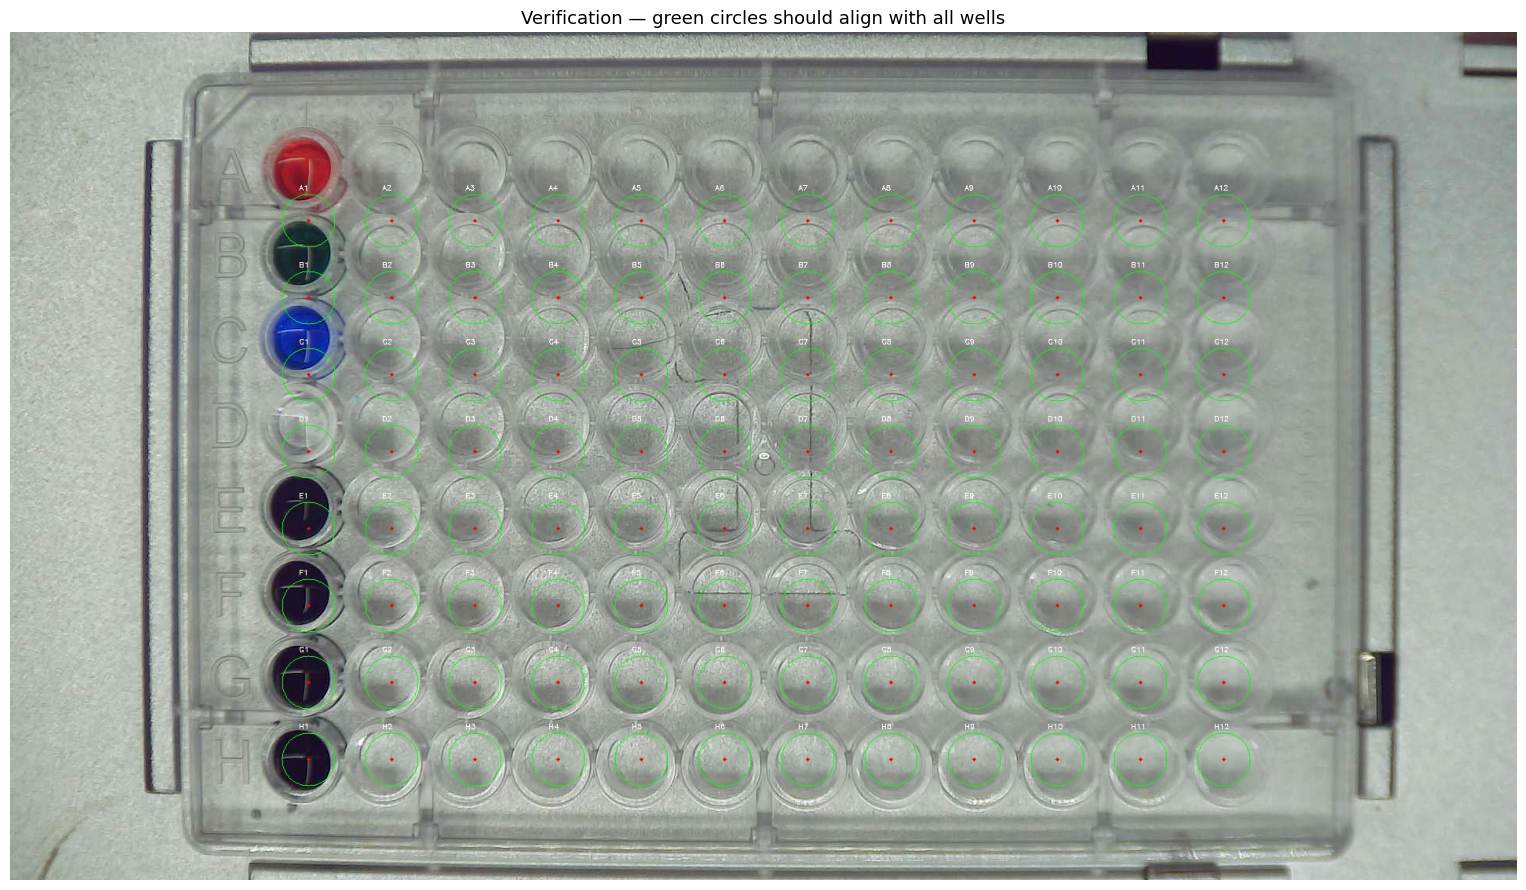


Grid applied! All extract_* calls now use: {'origin_x': 380, 'origin_y': 240, 'spacing_x': 106, 'spacing_y': 98, 'roi_radius': 34}


In [16]:
# ==========================================================
# Enter 3 corner well coordinates and compute + apply grid
# ==========================================================
from src.color_extraction import visualize_grid
import src.color_extraction as ce

# ===== ENTER YOUR COORDINATES HERE =====
A1  = (380, 240)   # (x, y) center of well A1  (red, top-left)
A12 = (1550, 240)  # (x, y) center of well A12 (empty, top-right)
H1  = (375, 925)   # (x, y) center of well H1  (dark, bottom-left)

# Compute grid from the 3 corners
spacing_x = (A12[0] - A1[0]) / 11.0   # 11 gaps across 12 columns
spacing_y = (H1[1] - A1[1]) / 7.0     # 7 gaps across 8 rows

cal_grid = {
    "origin_x": A1[0],
    "origin_y": A1[1],
    "spacing_x": int(round(spacing_x)),
    "spacing_y": int(round(spacing_y)),
    "roi_radius": int(round(min(abs(spacing_x), abs(spacing_y)) * 0.35)),
}

print(f"Computed grid:")
print(f"  origin:     ({cal_grid['origin_x']}, {cal_grid['origin_y']})")
print(f"  spacing:    ({cal_grid['spacing_x']}, {cal_grid['spacing_y']})")
print(f"  roi_radius: {cal_grid['roi_radius']}")

# Show overlay for verification
grid_path = visualize_grid(cal_image, grid=cal_grid)
grid_img = cv2.cvtColor(cv2.imread(grid_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 9))
plt.imshow(grid_img)
plt.title("Verification — green circles should align with all wells", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# Apply to color_extraction module
ce.DEFAULT_GRID.update(cal_grid)
print(f"\nGrid applied! All extract_* calls now use: {ce.DEFAULT_GRID}")

Capturing plate image for column 1...
[openot2.vision.camera] Camera 0 opened (1920x1080, backend=1200)
[openot2.vision.camera] Camera released
Image saved: ../data/seed_captures/col1_seed_20260219_130226.jpg

  COLUMN 1 SEED DATA
  Volumes: Vr=100.0, Vg=50.0, Vb=50.0
  Mean RGB: (82, 63, 93)
  Std RGB:  (1.1, 1.3, 2.6)
  Target:   (128, 0, 255)
  Distance: 180.0

  E1: R=83  G=65  B=96
  F1: R=83  G=65  B=95
  G1: R=81  G=63  B=92
  H1: R=80  G=62  B=90

  Controls:
    A1 (  Red): R=244  G=96  B=113
    B1 (Green): R=89  G=103  B=112
    C1 ( Blue): R=75  G=97  B=244
    D1 (Water): R=255  G=255  B=255


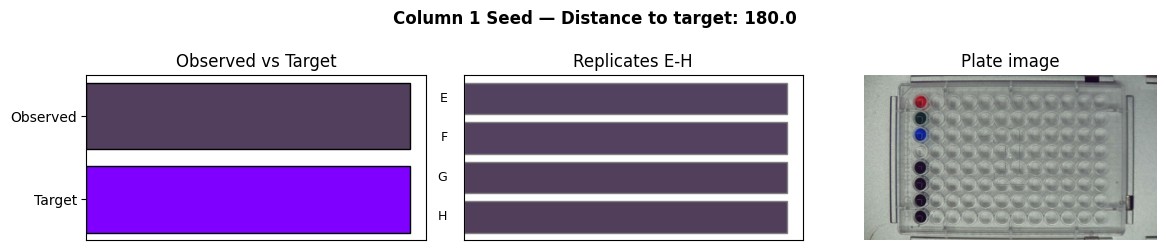


seed_X = [[100.  50.  50.]]
seed_Y = [[81.85005049 63.47120939 93.03255002]]

Seed data ready. Run the next cell to start active learning from column 2.


In [26]:
# ==========================================================
# Capture column 1 image and extract RGB for GP seeding
# ==========================================================
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
from openot2.vision import USBCamera
from src.color_extraction import extract_experiment_rgb
from src.ml import color_distance

# EDIT THIS: Enter the volumes you used for column 1's experiment wells (E-H)
col1_volumes = np.array([100.0, 50.0, 50.0])  # [Vr, Vg, Vb] in µL — CHANGE TO YOUR ACTUAL VALUES
assert abs(col1_volumes.sum() - TOTAL_VOLUME) < 1e-6, \
    f"Volumes must sum to {TOTAL_VOLUME}, got {col1_volumes.sum()}"

# --- Step 1: Capture plate image ---
print("Capturing plate image for column 1...")
cam_cfg = config.get("camera", {})
camera = USBCamera(
    camera_id=cam_cfg.get("device_id", 1),
    width=cam_cfg.get("width", 1920),
    height=cam_cfg.get("height", 1080),
    warmup_frames=cam_cfg.get("warmup_frames", 10),
)

os.makedirs("../data/seed_captures", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
seed_image_path = f"../data/seed_captures/col1_seed_{timestamp}.jpg"

with camera:
    frame = camera.capture()
    if frame is None:
        raise RuntimeError("Camera capture failed — check connection")
    cv2.imwrite(seed_image_path, frame)
print(f"Image saved: {seed_image_path}")

# --- Step 2: Extract experiment RGB from column 1 (uses calibrated grid) ---
result = extract_experiment_rgb(
    image_path=seed_image_path,
    col=0,  # column 1 = index 0
    experiment_rows=["E", "F", "G", "H"],
    control_rows=["A", "B", "C", "D"],
)

exp_rgb = result["experiment_rgb"]         # (4, 3) per-replicate
col1_mean_rgb = result["experiment_mean"]  # (3,) mean across E-H
col1_std_rgb = result["experiment_std"]    # (3,) std across E-H
ctrl_rgb = result["control_rgb"]           # dict: row label -> (3,) RGB

# --- Step 3: Display results ---
print(f"\n{'='*50}")
print(f"  COLUMN 1 SEED DATA")
print(f"{'='*50}")
print(f"  Volumes: Vr={col1_volumes[0]:.1f}, Vg={col1_volumes[1]:.1f}, Vb={col1_volumes[2]:.1f}")
print(f"  Mean RGB: ({col1_mean_rgb[0]:.0f}, {col1_mean_rgb[1]:.0f}, {col1_mean_rgb[2]:.0f})")
print(f"  Std RGB:  ({col1_std_rgb[0]:.1f}, {col1_std_rgb[1]:.1f}, {col1_std_rgb[2]:.1f})")
print(f"  Target:   ({TARGET_RGB[0]:.0f}, {TARGET_RGB[1]:.0f}, {TARGET_RGB[2]:.0f})")
dist = color_distance(col1_mean_rgb, TARGET_RGB)
print(f"  Distance: {dist:.1f}")
print()

# Per-replicate detail
for i, row in enumerate(["E", "F", "G", "H"]):
    rgb = exp_rgb[i]
    print(f"  {row}1: R={rgb[0]:.0f}  G={rgb[1]:.0f}  B={rgb[2]:.0f}")

# Controls
print(f"\n  Controls:")
for label in ["A", "B", "C", "D"]:
    rgb = ctrl_rgb.get(label, np.zeros(3))
    role = {"A": "Red", "B": "Green", "C": "Blue", "D": "Water"}[label]
    print(f"    {label}1 ({role:>5}): R={rgb[0]:.0f}  G={rgb[1]:.0f}  B={rgb[2]:.0f}")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 2.5))
obs_norm = np.clip(col1_mean_rgb / 255.0, 0, 1)
tgt_norm = np.clip(TARGET_RGB / 255.0, 0, 1)

axes[0].barh(1, 1, color=obs_norm, edgecolor="black")
axes[0].barh(0, 1, color=tgt_norm, edgecolor="black")
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(["Target", "Observed"])
axes[0].set_xticks([])
axes[0].set_title("Observed vs Target")

for i, (row, rgb) in enumerate(zip(["E", "F", "G", "H"], exp_rgb)):
    axes[1].barh(3 - i, 1, color=np.clip(rgb / 255.0, 0, 1), edgecolor="gray")
    axes[1].text(-0.05, 3 - i, row, ha="right", va="center", fontsize=9)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Replicates E-H")

img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
axes[2].imshow(img_rgb)
axes[2].set_title("Plate image")
axes[2].axis("off")

plt.suptitle(f"Column 1 Seed — Distance to target: {dist:.1f}", fontweight="bold")
plt.tight_layout()
plt.show()

# --- Step 4: Store as seed arrays for the active learning loop ---
seed_X = col1_volumes.reshape(1, 3)
seed_Y = col1_mean_rgb.reshape(1, 3)

print(f"\nseed_X = {seed_X}")
print(f"seed_Y = {seed_Y}")
print(f"\nSeed data ready. Run the next cell to start active learning from column 2.")

---
## 5. Run Full Active Learning Experiment

This calls `run_active_learning_loop()` which handles:
- Phase 1: Controls (left single-channel) + Experiments (right 8-channel)
- Phase 2: Settle → image → extract RGB → update GPs
- Convergence check after each iteration

[openot2.client] POST http://169.254.8.56:31950/runs
[openot2.client] Run created: c249821f-913c-4591-8536-47572b8ee413
[openot2.client] loadPipette: p300_multi_gen2 (right)
[openot2.client] Pipette ID: 4670a559-5a61-4a0b-95ba-aed764c1ae4f (mount=right)
[openot2.client] loadPipette: p300_single_gen2 (left)
[openot2.client] Pipette ID: 08d05393-9bba-40ea-aa4e-065ad4c823bf (mount=left)
[openot2.client] loadLabware: opentrons_96_filtertiprack_200ul in slot 11
[openot2.client] Labware ID: 9ecb9adb-031a-4435-bfc8-1fc7681362fd
[openot2.client] loadLabware: opentrons_96_filtertiprack_200ul in slot 10
[openot2.client] Labware ID: 9f8f0a2f-5b46-4854-b159-b767163d3866
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 7
[openot2.client] Labware ID: dd85b8d0-eb8a-42e4-ad80-a08c8824e4ee
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 8
[openot2.client] Labware ID: 49173c78-5970-4e79-8d8b-69d78fda8ba2
[openot2.client] loadLabware: nest_12_reservoir_15ml in slot 9
[openot2.cli

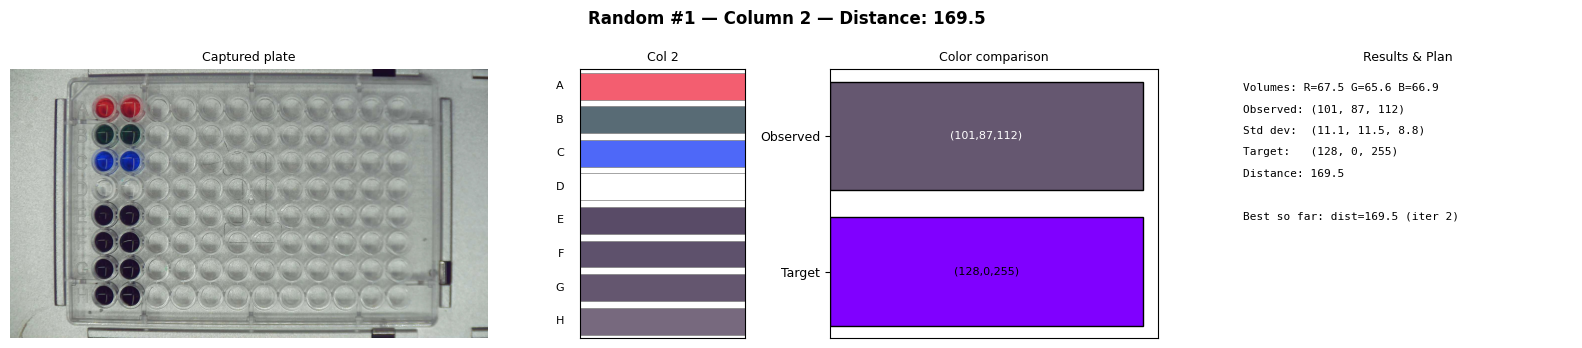


--- Random experiment 2/5 (column 3) ---
    Volumes: Vr=30.8, Vg=9.5, Vb=159.7
  [Phase 1] Controls (column 3)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A3 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A3 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.operations] transfer: A1 -> B3 (2

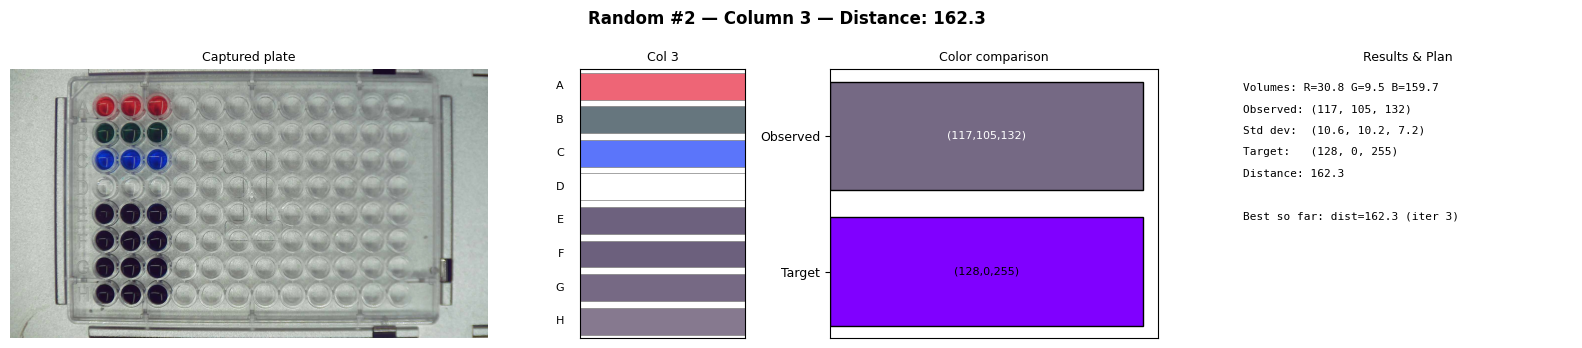


--- Random experiment 3/5 (column 4) ---
    Volumes: Vr=61.1, Vg=135.4, Vb=3.4
  [Phase 1] Controls (column 4)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A4 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A4 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.operations] transfer: A1 -> B4 (2

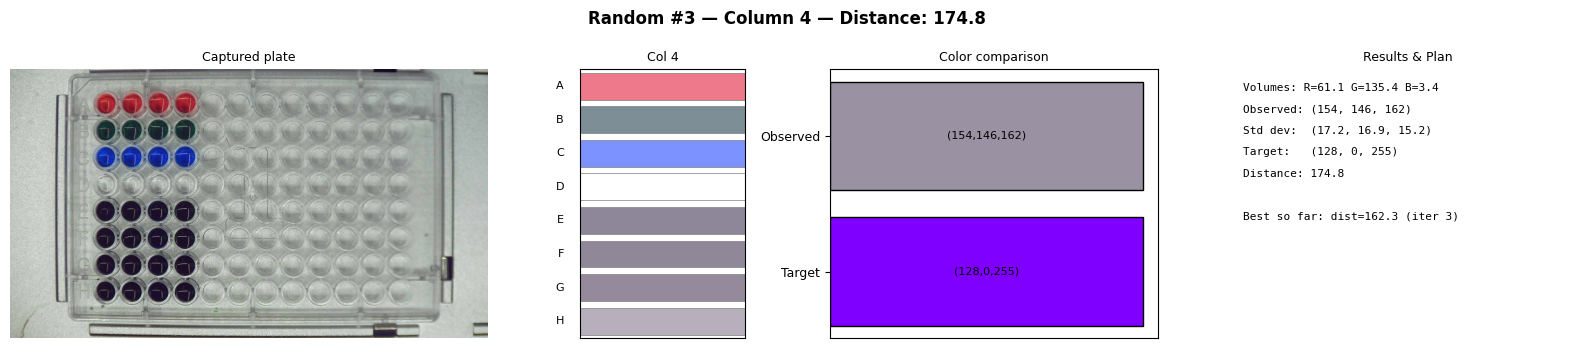


--- Random experiment 4/5 (column 5) ---
    Volumes: Vr=94.9, Vg=6.4, Vb=98.7
  [Phase 1] Controls (column 5)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A5 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A5 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.operations] transfer: A1 -> B5 (20

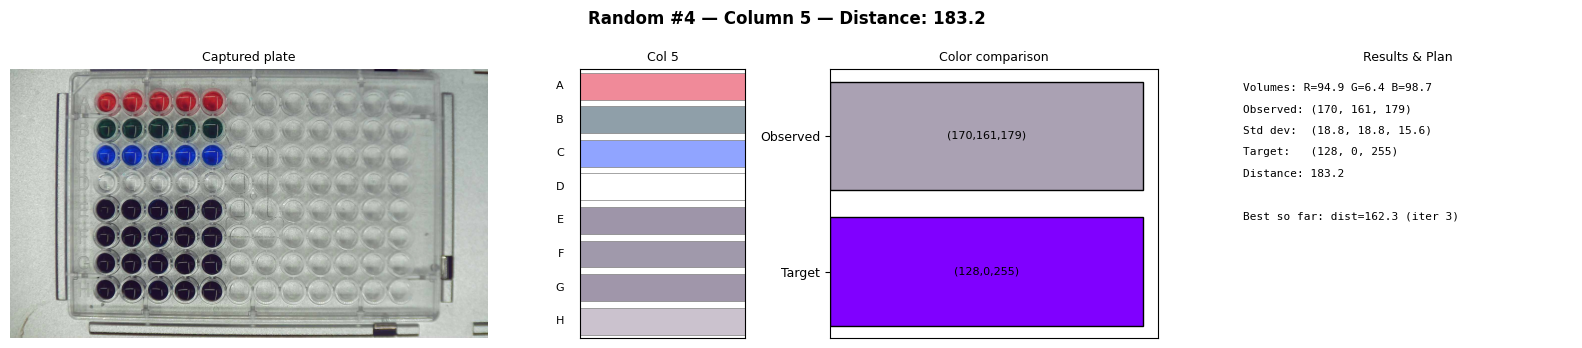


--- Random experiment 5/5 (column 6) ---
    Volumes: Vr=103.4, Vg=23.1, Vb=73.5
  [Phase 1] Controls (column 6)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A6 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A6 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.operations] transfer: A1 -> B6 (

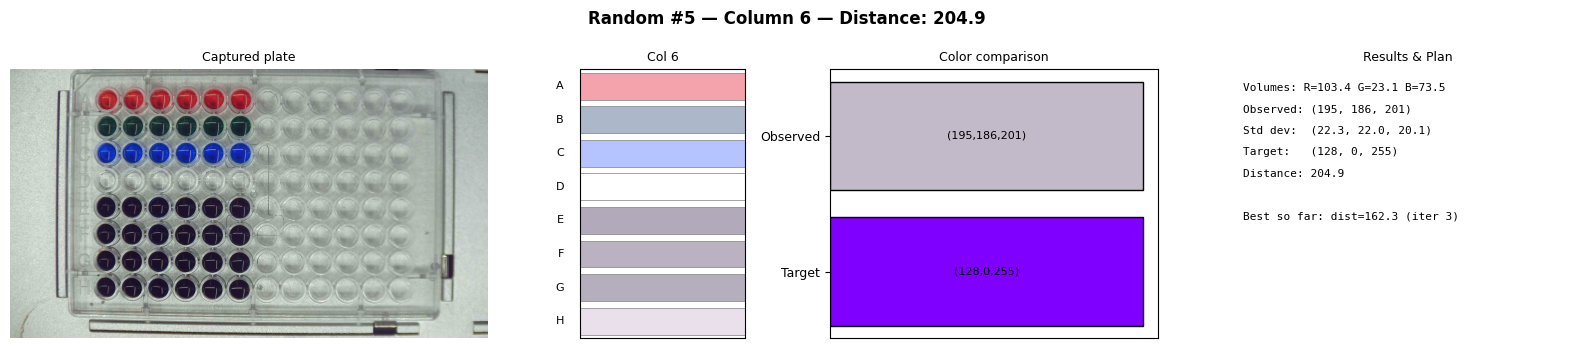

[ML] CorrelatedGP fitted on 6 points (3 correlated outputs)

  PHASE 2: 7 Bayesian optimization iterations



/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=18.7, Vg=95.7, Vb=85.6 | Pred RGB=(136,124,146) | Score=58.9

--- BO iteration 1/7 (column 7) ---
    Suggested: Vr=18.7, Vg=95.7, Vb=85.6
  [Phase 1] Controls (column 7)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A7 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A7 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=37.4, Vg=118.7, Vb=43.9 | Pred RGB=(152,142,161) | Score=33.8


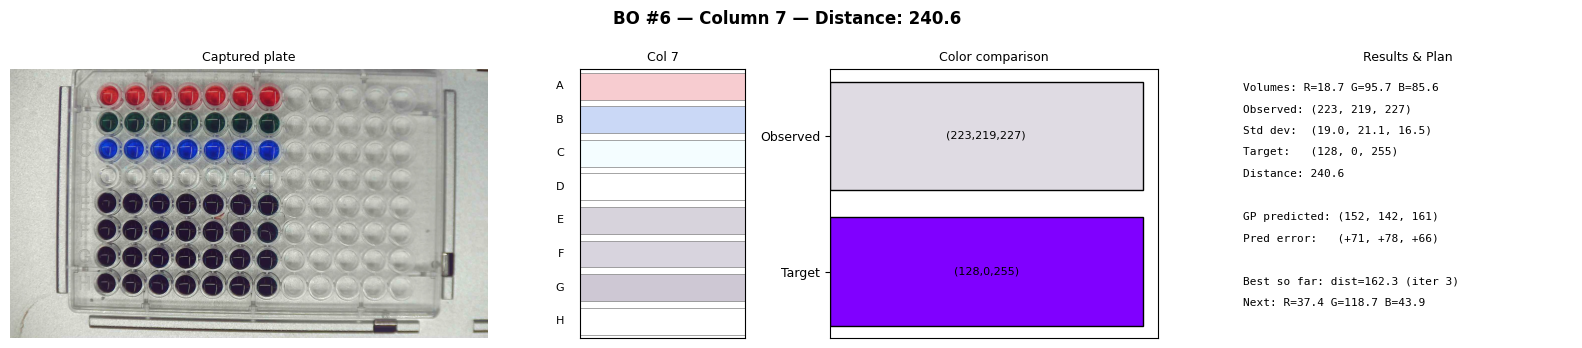

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=90.2, Vg=46.1, Vb=63.7 | Pred RGB=(152,142,161) | Score=19.7

--- BO iteration 2/7 (column 8) ---
    Suggested: Vr=90.2, Vg=46.1, Vb=63.7
  [Phase 1] Controls (column 8)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A8 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A8 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=80.8, Vg=40.3, Vb=78.9 | Pred RGB=(158,149,167) | Score=19.1


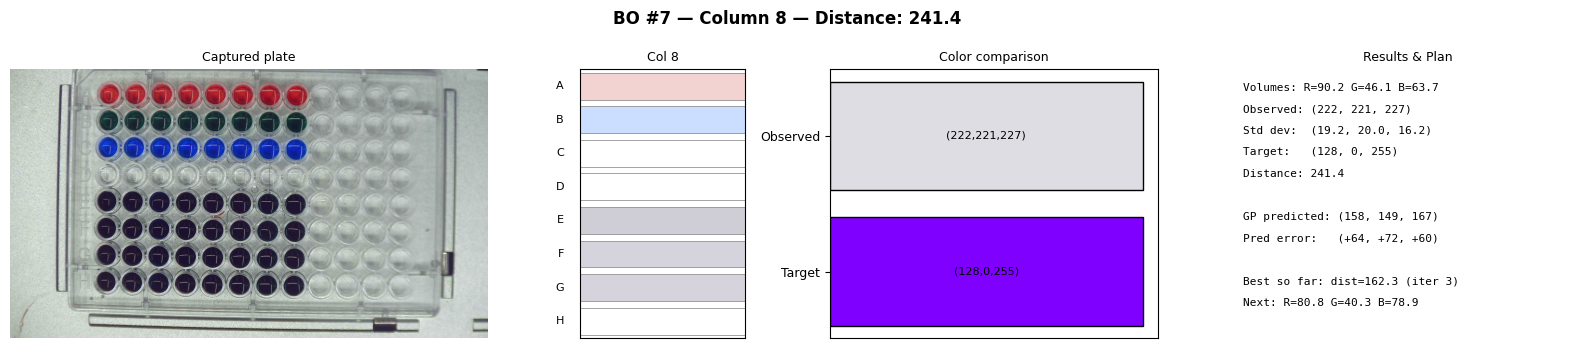

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=181.6, Vg=15.0, Vb=3.4 | Pred RGB=(158,149,167) | Score=26.4

--- BO iteration 3/7 (column 9) ---
    Suggested: Vr=181.6, Vg=15.0, Vb=3.4
  [Phase 1] Controls (column 9)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A9 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A9 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f-5

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=1.4, Vg=177.0, Vb=21.6 | Pred RGB=(167,157,174) | Score=12.5


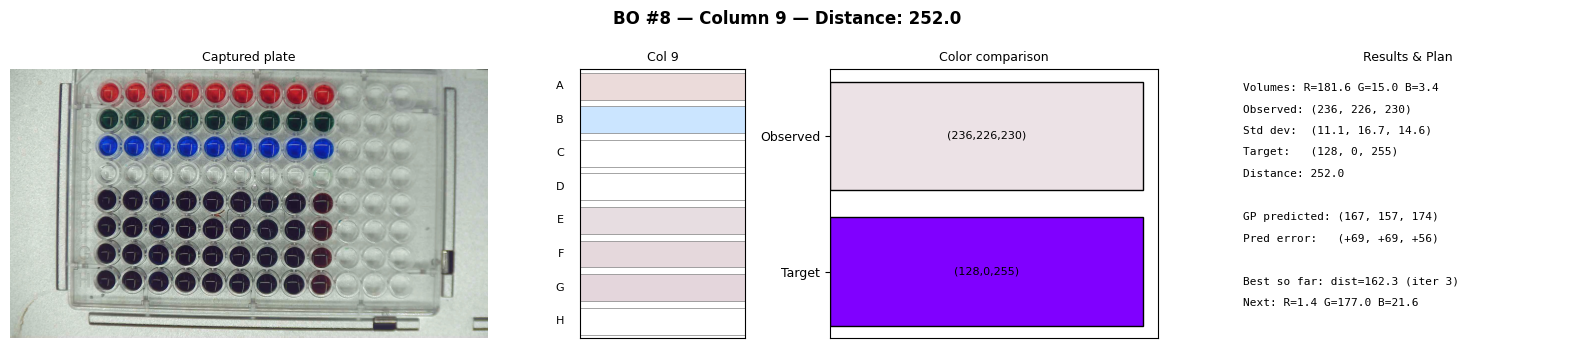

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=47.4, Vg=128.6, Vb=24.0 | Pred RGB=(167,157,174) | Score=30.0

--- BO iteration 4/7 (column 10) ---
    Suggested: Vr=47.4, Vg=128.6, Vb=24.0
  [Phase 1] Controls (column 10)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A10 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A10 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=4.6, Vg=127.4, Vb=68.0 | Pred RGB=(173,164,178) | Score=0.1


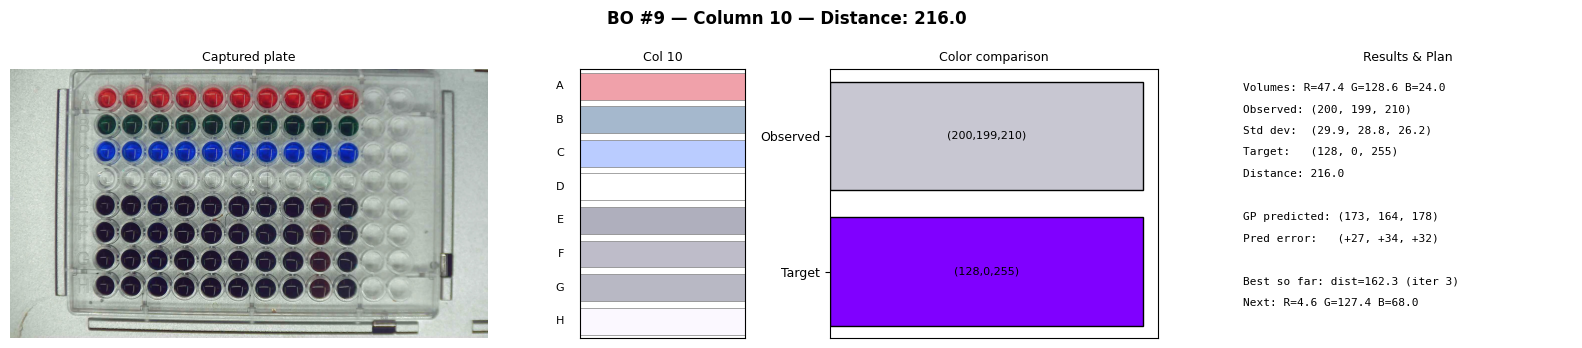

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=50.9, Vg=23.9, Vb=125.2 | Pred RGB=(172,164,178) | Score=0.6

--- BO iteration 5/7 (column 11) ---
    Suggested: Vr=50.9, Vg=23.9, Vb=125.2
  [Phase 1] Controls (column 11)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A11 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A11 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=13.9, Vg=173.8, Vb=12.3 | Pred RGB=(171,163,178) | Score=23.1


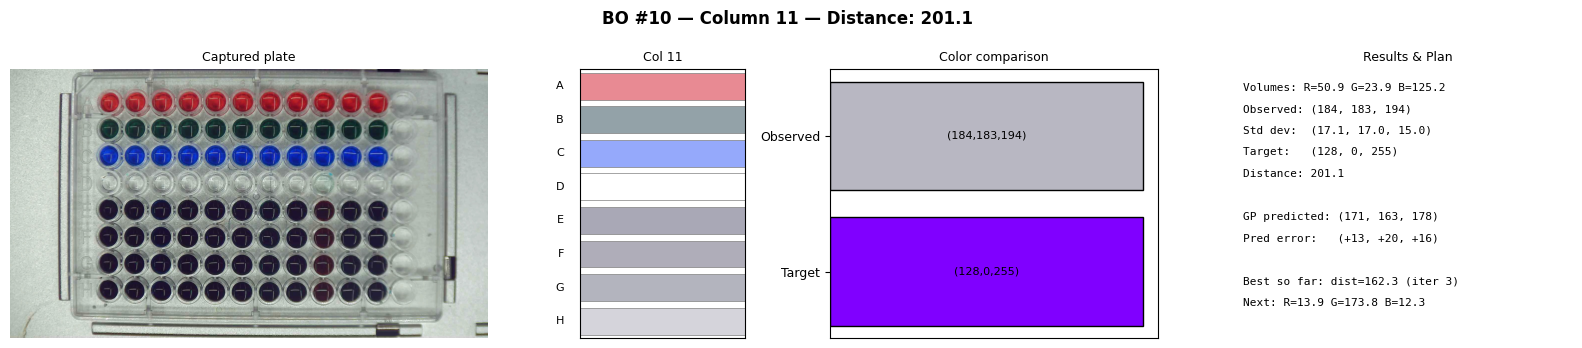

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=97.7, Vg=98.0, Vb=4.3 | Pred RGB=(171,163,178) | Score=31.0

--- BO iteration 6/7 (column 12) ---
    Suggested: Vr=97.7, Vg=98.0, Vb=4.3
  [Phase 1] Controls (column 12)
[openot2.client] Active pipette switched to left (08d05393-9bba-40ea-aa4e-065ad4c823bf)
[openot2.operations] transfer: A1 -> A12 (200.0 uL) tip=A1
[openot2.client] pickUpTip: labware=9f8f0a2f-5b46-4854-b159-b767163d3866 well=A1
[openot2.client] aspirate: 200.0uL from A1 origin=bottom
[openot2.client] dispense: 200.0uL into A12 origin=bottom
[openot2.client] blowout
[openot2.operations] rinse: A6 x3 (200.0 uL)
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] aspirate: 200uL from A6 origin=bottom
[openot2.client] dispense: 200uL into A6 origin=bottom
[openot2.client] blowout
[openot2.client] dropTip: labware=9f8f0a2f

/Users/tuomasier/miniconda3/envs/automation/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


[ML] Suggested: Vr=60.1, Vg=126.8, Vb=13.1 | Pred RGB=(172,165,180) | Score=29.4


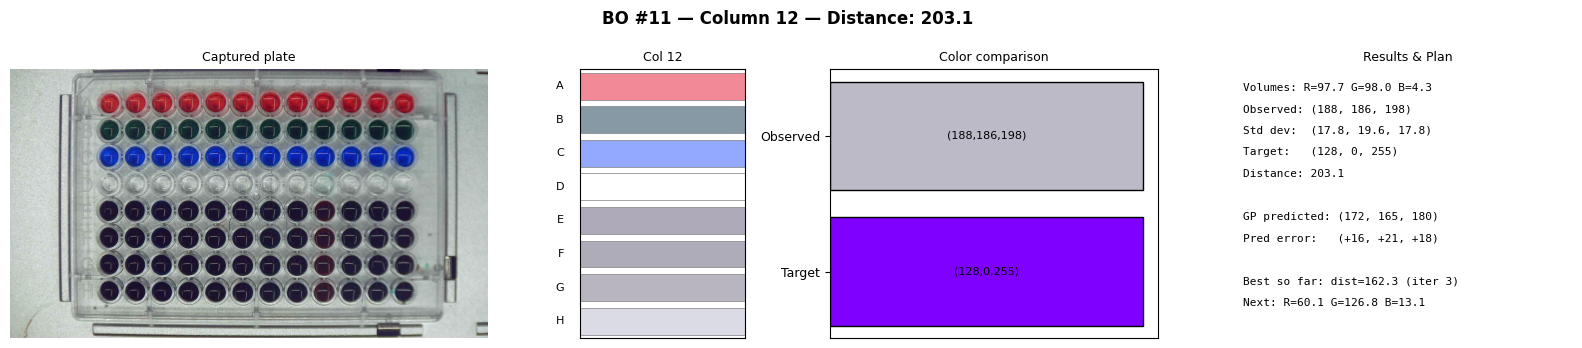


*** PLATE FULL — pausing for plate swap ***
[openot2.client] home


KeyboardInterrupt: 

In [27]:
# Run the active learning loop, seeded with column 1 data
# (creates its own OT2Client + OT2Operations internally from config)
all_X, all_Y, all_dist = run_active_learning_loop(
    config_path="../configs/experiment.yaml",
    start_column=1,
    seed_X=seed_X,    # from 4c: column 1 volumes
    seed_Y=seed_Y,    # from 4c: column 1 observed RGB
)

---
## 6. Results & Visualization

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Convergence plot
axes[0].plot(all_dist, "o-", color="purple")
axes[0].axhline(y=config.get("convergence_threshold", 50), color="r", linestyle="--", label="Threshold")
axes[0].axvline(x=config["experiment"]["n_initial"] - 0.5, color="gray", linestyle=":", label="Random → BO")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("RGB Distance to Target")
axes[0].set_title("Convergence")
axes[0].legend()

# Volume allocation over iterations
axes[1].stackplot(range(len(all_X)),
                  all_X[:, 0], all_X[:, 1], all_X[:, 2],
                  labels=["Vr (Red)", "Vg (Green)", "Vb (Blue)"],
                  colors=["red", "green", "blue"], alpha=0.7)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Volume (µL)")
axes[1].set_title("Volume Allocation")
axes[1].legend(loc="upper right")

# Observed vs target RGB
best_idx = np.argmin(all_dist)
colors_observed = all_Y / 255.0
for i in range(len(all_Y)):
    axes[2].scatter(i, 0, color=np.clip(colors_observed[i], 0, 1), s=200, marker="s")
target_norm = np.clip(TARGET_RGB / 255.0, 0, 1)
axes[2].axhline(y=0, color="gray", linewidth=0.5)
axes[2].scatter(len(all_Y) + 1, 0, color=target_norm, s=300, marker="*", edgecolors="black", label="Target")
axes[2].set_xlabel("Iteration")
axes[2].set_title("Observed Colors (squares) vs Target (star)")
axes[2].set_yticks([])
axes[2].legend()

plt.tight_layout()
plt.savefig("../data/results/convergence_plot.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nBest result: iteration {best_idx+1}")
print(f"  Distance: {all_dist[best_idx]:.1f}")
print(f"  Volumes: Vr={all_X[best_idx][0]:.1f}, Vg={all_X[best_idx][1]:.1f}, Vb={all_X[best_idx][2]:.1f}")
print(f"  RGB: ({all_Y[best_idx][0]:.0f}, {all_Y[best_idx][1]:.0f}, {all_Y[best_idx][2]:.0f})")
print(f"  Target: ({TARGET_RGB[0]:.0f}, {TARGET_RGB[1]:.0f}, {TARGET_RGB[2]:.0f})")